# Martinet & Satoh (2007) Replication: Visual Phrase Mining

This notebook follows the pipeline: visual words -> 3x3 window transactions -> Apriori rules -> symmetric merge -> visual phrases -> evaluation. It is a lightweight, reproducible approximation of the CBMI'07 procedure for a small image dataset.


## A. Setup & Imports

Install any missing dependencies and set global configuration.


In [100]:
try:
    import mlxtend  # noqa: F401
except Exception:
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "mlxtend"])


In [101]:
import os
from pathlib import Path
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.cluster import MiniBatchKMeans

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

try:
    from PIL import Image
except Exception:
    Image = None

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["image.interpolation"] = "nearest"


In [ ]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

DATASET_SOURCE = "folder" 
DATA_DIR = "/Users/dylesm/.cache/kagglehub/datasets/vesuvius13/formula-one-cars/versions/1/"
N_IMAGES = 300
IMG_SIZE = (256, 256)

PATCH_SIZE = 16
PATCH_STRIDE = 32
FEATURE_SIZE = 8
GRAYSCALE = False

K = 128
WINDOW_SIZE = 5
MIN_SUPPORT = 0.002
MIN_CONF = 0.3
MAX_MERGES = 15
MAX_ITEMSET = 2

PAIRWISE_SAMPLE = 1500
DISCRIM_SAMPLE = 200


In [103]:
RUNS_DIR = "runs"
def _safe_token(x):
    return str(x).replace(' ', '').replace('/', '-')

def _next_run_id(base_dir):
    base = Path(base_dir)
    base.mkdir(parents=True, exist_ok=True)
    existing = [p for p in base.iterdir() if p.is_dir() and p.name.startswith('run_')]
    ids = []
    for p in existing:
        try:
            ids.append(int(p.name.split('_')[1]))
        except Exception:
            pass
    return max(ids, default=0) + 1

run_id = _next_run_id(RUNS_DIR)
param_tag = f"ps{PATCH_SIZE}_ws{WINDOW_SIZE}_k{K}_ms{MIN_SUPPORT}_mc{MIN_CONF}"
RUN_DIR = str(Path(RUNS_DIR) / f"run_{run_id:03d}_{_safe_token(param_tag)}")
Path(RUN_DIR).mkdir(parents=True, exist_ok=True)
print('Run dir:', RUN_DIR)


Run dir: runs/run_005_ps16_ws5_k128_ms0.002_mc0.3


## B. Dataset Loading

The loader prefers a local `data/` folder if present. Otherwise it tries CIFAR-10 (if torchvision is installed), then falls back to sample or synthetic images for full offline reproducibility.


In [104]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def resize_image(img, size):
    target_h, target_w = size
    if img.shape[0] == target_h and img.shape[1] == target_w:
        return img
    if Image is not None:
        pil = Image.fromarray(img.astype(np.uint8))
        pil = pil.resize((target_w, target_h), resample=Image.BILINEAR)
        return np.asarray(pil)
    h, w = img.shape[:2]
    y_idx = (np.linspace(0, h - 1, target_h)).astype(int)
    x_idx = (np.linspace(0, w - 1, target_w)).astype(int)
    return img[y_idx][:, x_idx]

def load_image_path(path, size):
    try:
        if Image is not None:
            img = Image.open(path).convert("RGB")
            img = img.resize((size[1], size[0]), resample=Image.BILINEAR)
            return np.asarray(img)
        import matplotlib.image as mpimg
        img = mpimg.imread(path)
        if img.ndim == 2:
            img = np.stack([img] * 3, axis=-1)
        if img.shape[2] == 4:
            img = img[:, :, :3]
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        return resize_image(img, size)
    except Exception:
        return None

def load_folder_images(path, max_images, size):
    paths = [p for p in Path(path).rglob("*") if p.suffix.lower() in IMG_EXTS]
    if not paths:
        return []
    rng.shuffle(paths)
    imgs = []
    for p in paths[:max_images]:
        img = load_image_path(p, size)
        if img is not None:
            imgs.append(img)
    return imgs

def load_cifar10(max_images, size, download=False):
    try:
        from torchvision.datasets import CIFAR10
        from torchvision import transforms
    except Exception as e:
        print("torchvision not available:", e)
        return []
    transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
    ds = CIFAR10(root="data", train=True, download=download, transform=transform)
    imgs = []
    for i in range(min(max_images, len(ds))):
        x, _ = ds[i]
        img = (x.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        imgs.append(img)
    return imgs

def load_sample_images_augmented(max_images, size):
    from sklearn.datasets import load_sample_images
    base = load_sample_images().images
    out = []
    for _ in range(max_images):
        img = base[rng.integers(0, len(base))]
        h, w = img.shape[:2]
        crop = rng.integers(int(0.6 * min(h, w)), min(h, w) + 1)
        y = rng.integers(0, h - crop + 1)
        x = rng.integers(0, w - crop + 1)
        crop_img = img[y:y + crop, x:x + crop]
        out.append(resize_image(crop_img, size))
    return out

def load_synthetic(max_images, size):
    h, w = size
    out = []
    for _ in range(max_images):
        img = rng.integers(0, 40, size=(h, w, 3), dtype=np.uint8)
        for _ in range(rng.integers(3, 7)):
            y0 = rng.integers(0, h - 10)
            x0 = rng.integers(0, w - 10)
            hh = rng.integers(10, h // 2 + 1)
            ww = rng.integers(10, w // 2 + 1)
            color = rng.integers(50, 255, size=3, dtype=np.uint8)
            img[y0:y0 + hh, x0:x0 + ww] = color
        out.append(img)
    return out

def load_dataset(source):
    if source in ("auto", "folder"):
        if Path(DATA_DIR).exists():
            imgs = load_folder_images(DATA_DIR, N_IMAGES, IMG_SIZE)
            if imgs:
                return imgs, "folder"
    if source in ("auto", "cifar10"):
        imgs = load_cifar10(N_IMAGES, IMG_SIZE, download=False)
        if imgs:
            return imgs, "cifar10"
    if source in ("auto", "sample"):
        imgs = load_sample_images_augmented(N_IMAGES, IMG_SIZE)
        if imgs:
            return imgs, "sample_images"
    return load_synthetic(N_IMAGES, IMG_SIZE), "synthetic"

images, source_name = load_dataset(DATASET_SOURCE)
print(f"Loaded {len(images)} images from {source_name}")


/Users/dylesm/Frugal/.venv/lib/python3.11/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loaded 300 images from folder


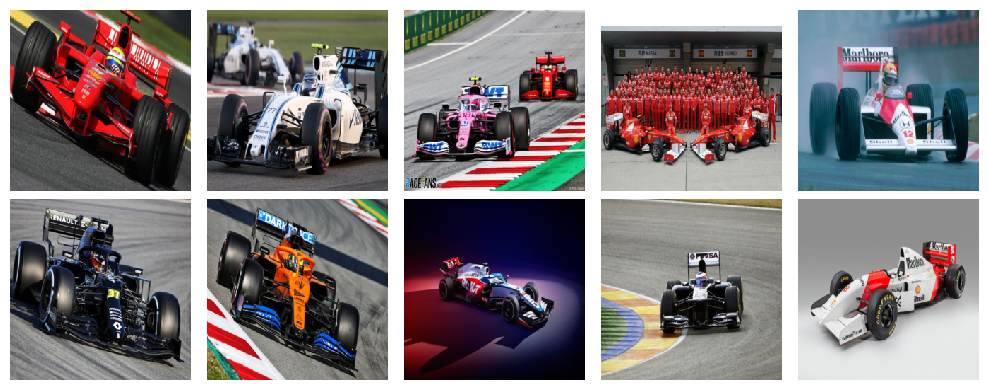

In [105]:
def show_image_grid(imgs, n=10):
    n = min(n, len(imgs))
    if n == 0:
        print("No images loaded.")
        return
    cols = 5
    rows = int(math.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = np.array(axes).reshape(rows, cols)
    for ax in axes.ravel():
        ax.axis("off")
    for i, img in enumerate(imgs[:n]):
        ax = axes.ravel()[i]
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()

show_image_grid(images, n=10)


## C. Patch Extraction (parameterizable)

Patches are extracted directly from raw images and converted to compact features for k-means.

In [106]:
def extract_patches(img, patch_size, stride):
    h, w = img.shape[:2]
    h2 = (h // patch_size) * patch_size
    w2 = (w // patch_size) * patch_size
    img = img[:h2, :w2]
    patches = []
    positions = []
    for y in range(0, h2 - patch_size + 1, stride):
        for x in range(0, w2 - patch_size + 1, stride):
            patches.append(img[y:y + patch_size, x:x + patch_size])
            positions.append((y, x))
    grid_h = (h2 - patch_size) // stride + 1
    grid_w = (w2 - patch_size) // stride + 1
    return patches, positions, (grid_h, grid_w)

def patch_to_feature(patch, feature_size=8, grayscale=False):
    if grayscale:
        patch = patch.mean(axis=2, keepdims=True)
    h = patch.shape[0]
    if feature_size is not None and h != feature_size:
        if h % feature_size == 0:
            bin_size = h // feature_size
            patch = patch.reshape(feature_size, bin_size, feature_size, bin_size, patch.shape[2]).mean(axis=(1, 3))
        else:
            if Image is not None:
                pil = Image.fromarray(patch.astype(np.uint8))
                pil = pil.resize((feature_size, feature_size), resample=Image.BILINEAR)
                patch = np.asarray(pil)
                if grayscale:
                    patch = patch.mean(axis=2, keepdims=True)
            else:
                patch = resize_image(patch, (feature_size, feature_size))
                if grayscale:
                    patch = patch.mean(axis=2, keepdims=True)

    base_feat = patch.astype(np.float32).reshape(-1) / 255.0
    patch_f = patch.astype(np.float32)

    if grayscale:
        gray = patch_f[..., 0]
        stats = np.array([gray.mean(), gray.min(), gray.max(), np.median(gray)], dtype=np.float32)
    else:
        stats_list = []
        for ch in range(patch_f.shape[2]):
            vals = patch_f[..., ch]
            stats_list.extend([vals.mean(), vals.min(), vals.max(), np.median(vals)])
        stats = np.array(stats_list, dtype=np.float32)

    feat = np.concatenate([base_feat, stats / 255.0])
    return feat


all_patches = []
all_features = []
image_patch_slices = []

for img in tqdm(images, desc="Extracting patches"):
    patches, positions, grid_shape = extract_patches(img, PATCH_SIZE, PATCH_STRIDE)
    feats = [patch_to_feature(p, FEATURE_SIZE, GRAYSCALE) for p in patches]
    start = len(all_patches)
    all_patches.extend(patches)
    all_features.extend(feats)
    end = len(all_patches)
    image_patch_slices.append((start, end, grid_shape))

features = np.stack(all_features) if all_features else np.empty((0, 0), dtype=np.float32)
print("Total patches:", len(all_patches), "Feature dim:", features.shape[1])


Extracting patches: 100%|██████████| 300/300 [00:01<00:00, 263.84it/s]

Total patches: 19200 Feature dim: 204


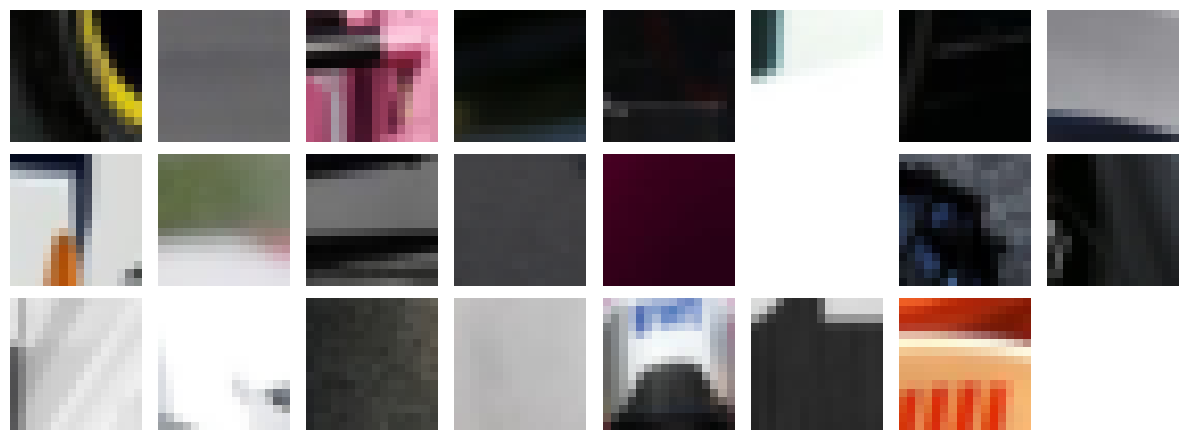

In [107]:
def show_patches(patches, n=16):
    n = min(n, len(patches))
    if n == 0:
        print("No patches to display.")
        return
    cols = 8
    rows = int(math.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
    axes = np.array(axes).reshape(rows, cols)
    for ax in axes.ravel():
        ax.axis("off")
    idx = rng.choice(len(patches), size=n, replace=False)
    for i, p in enumerate(idx):
        ax = axes.ravel()[i]
        ax.imshow(patches[p])
        ax.axis("off")
    plt.tight_layout()

show_patches(all_patches, n=24)


## D. Visual Word Clustering

Cluster patch features with k-means to obtain K visual words, then map each image to a 2D grid of word IDs.


Word grid shape: (8, 8) K: 128


(np.float64(-0.5), np.float64(7.5), np.float64(7.5), np.float64(-0.5))

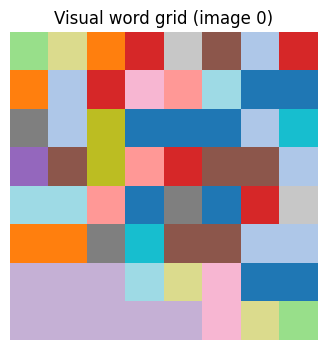

In [108]:
kmeans = MiniBatchKMeans(n_clusters=K, random_state=SEED, batch_size=256, n_init=3)
kmeans.fit(features)
labels = kmeans.predict(features)

word_grids = []
for start, end, grid_shape in image_patch_slices:
    grid = labels[start:end].reshape(grid_shape)
    word_grids.append(grid)

print("Word grid shape:", word_grids[0].shape, "K:", K)
plt.imshow(word_grids[0], cmap="tab20")
plt.title("Visual word grid (image 0)")
plt.axis("off")


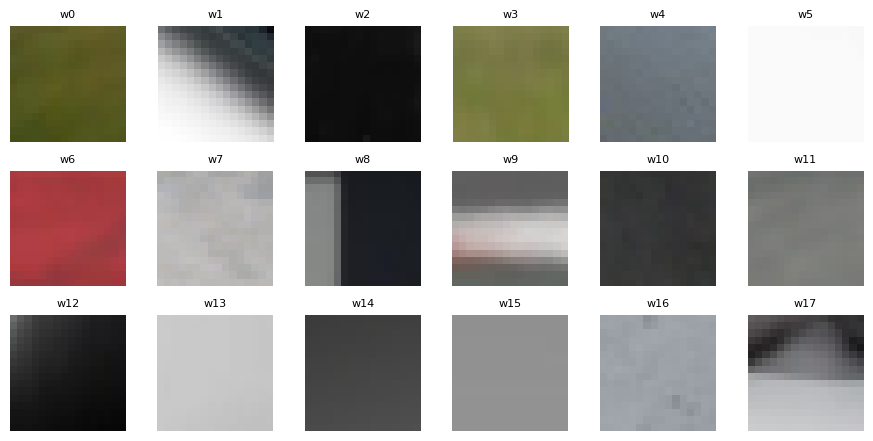

In [109]:
def select_exemplars(patches, features, labels, centers):
    n_words = centers.shape[0]
    best_idx = [-1] * n_words
    best_dist = [np.inf] * n_words
    for i, (lab, feat) in enumerate(zip(labels, features)):
        dist = np.linalg.norm(feat - centers[lab])
        if dist < best_dist[lab]:
            best_dist[lab] = dist
            best_idx[lab] = i
    exemplars = [patches[i] if i >= 0 else None for i in best_idx]
    return exemplars

word_exemplars = select_exemplars(all_patches, features, labels, kmeans.cluster_centers_)

def show_word_exemplars(exemplars, n=12):
    n = min(n, len(exemplars))
    cols = 6
    rows = int(math.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
    axes = np.array(axes).reshape(rows, cols)
    for ax in axes.ravel():
        ax.axis("off")
    for i in range(n):
        ax = axes.ravel()[i]
        if exemplars[i] is not None:
            ax.imshow(exemplars[i])
            ax.set_title(f"w{i}", fontsize=8)
        ax.axis("off")
    plt.tight_layout()

show_word_exemplars(word_exemplars, n=18)


## E. Transaction Construction (3x3 windows)

Each spatial window yields one transaction: the set of unique visual word IDs inside that window.


In [110]:
def build_transactions_from_grids(grids, window_size):
    tx_per_image = []
    for grid in grids:
        gh, gw = grid.shape
        txs = []
        for r in range(gh - window_size + 1):
            for c in range(gw - window_size + 1):
                window = grid[r:r + window_size, c:c + window_size]
                items = set(f"w{int(i)}" for i in np.unique(window))
                txs.append(items)
        tx_per_image.append(txs)
    return tx_per_image

tx_per_image = build_transactions_from_grids(word_grids, WINDOW_SIZE)
transactions = [list(t) for txs in tx_per_image for t in txs]
print("Transactions:", len(transactions))
print("Example transaction:", transactions[0] if transactions else [])


Transactions: 4800
Example transaction: ['w43', 'w36', 'w67', 'w53', 'w102', 'w41', 'w10', 'w108', 'w126', 'w45', 'w92', 'w6', 'w91', 'w95', 'w125', 'w83', 'w50', 'w14']


## F. Apriori Mining of Frequent Itemsets & Rules

Apriori is applied to the window transactions using explicit minsupport and minconfidence.


Note: to keep Apriori tractable, itemsets are capped at size 2 (antecedent and consequent are singletons).


In [111]:
def mine_rules(transactions, min_support, min_conf, max_itemset=2):
    if not transactions:
        return pd.DataFrame(), pd.DataFrame()
    encoder = TransactionEncoder()
    te = encoder.fit(transactions).transform(transactions)
    df = pd.DataFrame(te, columns=encoder.columns_)
    itemsets = apriori(df, min_support=min_support, use_colnames=True, max_len=max_itemset)
    if itemsets.empty:
        return itemsets, pd.DataFrame()
    rules = association_rules(itemsets, metric="confidence", min_threshold=min_conf)
    if rules.empty:
        return itemsets, rules
    rules = rules[(rules["antecedents"].apply(len) > 0) & (rules["consequents"].apply(len) > 0)]
    rules = rules[rules.apply(lambda r: r["antecedents"].isdisjoint(r["consequents"]), axis=1)]
    return itemsets, rules

itemsets, rules = mine_rules(transactions, MIN_SUPPORT, MIN_CONF, MAX_ITEMSET)
print("Frequent itemsets:", len(itemsets), "Rules:", len(rules))
if not rules.empty:
    display(rules.sort_values("confidence", ascending=False).head(10)[
        ["antecedents", "consequents", "support", "confidence", "lift"]
    ])


Frequent itemsets: 121145 Rules: 86811


,antecedents,consequents,support,confidence,lift
22015,"(w109, w56)",(w64),0.002500,1.0,14.414414
85536,"(w80, w9)",(w67),0.002083,1.0,6.169666
17388,"(w56, w106)",(w77),0.002500,1.0,4.251550
58604,"(w15, w90)",(w77),0.002917,1.0,4.251550
62950,"(w56, w83)",(w2),0.006250,1.0,3.013183
67258,"(w24, w78)",(w61),0.003333,1.0,3.983402
45668,"(w36, w90)",(w121),0.002500,1.0,5.139186
8098,"(w100, w84)",(w115),0.002708,1.0,5.111821
8907,"(w101, w15)",(w35),0.003333,1.0,11.034483
15706,"(w105, w41)",(w31),0.002708,1.0,3.715170


## G. Symmetric Rule Selection + Iterative Merging

We merge only when both X => Y and Y => X are strong. The new phrase token replaces X ∪ Y in all transactions, and rules are re-mined each iteration.


In [112]:
def doc_sets_from_transactions(tx_per_image):
    doc_sets = []
    for txs in tx_per_image:
        s = set()
        for items in txs:
            s.update(items)
        doc_sets.append(s)
    return doc_sets

def build_doc_matrix(doc_sets):
    vocab = sorted(set().union(*doc_sets)) if doc_sets else []
    idx = {t: i for i, t in enumerate(vocab)}
    mat = np.zeros((len(doc_sets), len(vocab)), dtype=np.float32)
    for i, s in enumerate(doc_sets):
        for t in s:
            mat[i, idx[t]] = 1.0
    return mat, vocab

def avg_cosine_to_centroid(mat):
    if mat.size == 0:
        return 0.0
    centroid = mat.mean(axis=0)
    denom = np.linalg.norm(centroid) + 1e-8
    if denom == 0:
        return 0.0
    centroid = centroid / denom
    norms = np.linalg.norm(mat, axis=1, keepdims=True) + 1e-8
    mat_norm = mat / norms
    sims = mat_norm.dot(centroid)
    return float(sims.mean())

def avg_pairwise_cosine(mat, n_pairs, rng):
    n = mat.shape[0]
    if n < 2:
        return 0.0
    n_pairs = min(n_pairs, n * (n - 1) // 2)
    idx1 = rng.integers(0, n, size=n_pairs)
    idx2 = rng.integers(0, n, size=n_pairs)
    mask = idx1 != idx2
    idx1, idx2 = idx1[mask], idx2[mask]
    if len(idx1) == 0:
        return 0.0
    a = mat[idx1]
    b = mat[idx2]
    a_norm = a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-8)
    b_norm = b / (np.linalg.norm(b, axis=1, keepdims=True) + 1e-8)
    sims = np.sum(a_norm * b_norm, axis=1)
    return float(sims.mean())

def avg_discriminative_power(mat, vocab, sample_n, rng):
    if mat.size == 0 or len(vocab) == 0:
        return 0.0
    base_density = avg_cosine_to_centroid(mat)
    n_vocab = len(vocab)
    if n_vocab > sample_n:
        idxs = rng.choice(n_vocab, size=sample_n, replace=False)
    else:
        idxs = np.arange(n_vocab)
    deltas = []
    for j in idxs:
        mat2 = mat.copy()
        mat2[:, j] = 0
        d = avg_cosine_to_centroid(mat2)
        deltas.append(base_density - d)
    return float(np.mean(deltas)) if deltas else 0.0

def compute_metrics(tx_per_image):
    doc_sets = doc_sets_from_transactions(tx_per_image)
    mat, vocab = build_doc_matrix(doc_sets)
    return {
        "density": avg_cosine_to_centroid(mat),
        "pairwise_sim": avg_pairwise_cosine(mat, PAIRWISE_SAMPLE, rng),
        "discriminative": avg_discriminative_power(mat, vocab, DISCRIM_SAMPLE, rng),
        "vocab_size": len(vocab),
        "n_docs": mat.shape[0],
    }

def find_best_symmetric_rule(rules):
    rule_map = {}
    for _, r in rules.iterrows():
        a = frozenset(r["antecedents"])
        c = frozenset(r["consequents"])
        rule_map[(a, c)] = (r["support"], r["confidence"])
    best = None
    for (a, c), (supp, conf) in rule_map.items():
        if (c, a) not in rule_map:
            continue
        supp2, conf2 = rule_map[(c, a)]
        avg_conf = (conf + conf2) / 2.0
        if best is None or avg_conf > best["avg_conf"]:
            best = {
                "a": a,
                "c": c,
                "avg_conf": avg_conf,
                "support": min(supp, supp2),
                "conf_pair": (conf, conf2),
            }
    return best

def apply_merge(tx_per_image, merge_items, new_token):
    merge_items = set(merge_items)
    new_tx = []
    for txs in tx_per_image:
        new_txs = []
        for items in txs:
            if merge_items.issubset(items):
                s = set(items)
                s.difference_update(merge_items)
                s.add(new_token)
                new_txs.append(s)
            else:
                new_txs.append(set(items))
        new_tx.append(new_txs)
    return new_tx

def merge_loop(tx_per_image, min_support, min_conf, max_merges, max_itemset=2):
    phrase_map = {}
    history = []
    metrics = [compute_metrics(tx_per_image)]
    next_phrase_id = 0

    for it in range(max_merges):
        transactions = [list(t) for txs in tx_per_image for t in txs]
        if not transactions:
            break
        _, rules = mine_rules(transactions, min_support, min_conf, max_itemset)
        if rules is None or rules.empty:
            break
        best = find_best_symmetric_rule(rules)
        if best is None:
            break

        merge_items = best["a"].union(best["c"])
        new_token = f"p{next_phrase_id}"
        next_phrase_id += 1

        base_set = set()
        for tok in merge_items:
            if tok.startswith("w"):
                base_set.add(int(tok[1:]))
            else:
                base_set.update(phrase_map.get(tok, set()))
        phrase_map[new_token] = base_set

        tx_per_image = apply_merge(tx_per_image, merge_items, new_token)
        history.append({
            "iteration": it + 1,
            "new_token": new_token,
            "items": sorted(merge_items),
            "avg_conf": best["avg_conf"],
            "support": best["support"],
        })
        metrics.append(compute_metrics(tx_per_image))

    return tx_per_image, phrase_map, history, metrics

merged_tx, phrase_map, merge_history, metrics = merge_loop(
    tx_per_image, MIN_SUPPORT, MIN_CONF, MAX_MERGES, MAX_ITEMSET
)
print("Merges:", len(merge_history), "Final vocab:", metrics[-1]["vocab_size"])
if merge_history:
    display(pd.DataFrame(merge_history).head())


Merges: 10 Final vocab: 137


,iteration,new_token,items,avg_conf,support
0,1,p0,"[w109, w64]",0.639789,0.052500
1,2,p1,"[w114, w2]",0.570329,0.207917
2,3,p2,"[w56, w76]",0.534245,0.050833
3,4,p3,"[w58, w61]",0.514157,0.141250
4,5,p4,"[w13, w7]",0.510611,0.096042


## H. Evaluation Metrics

We track density, average pairwise similarity, and discriminative power as merging progresses, plus vocabulary size for compactness.


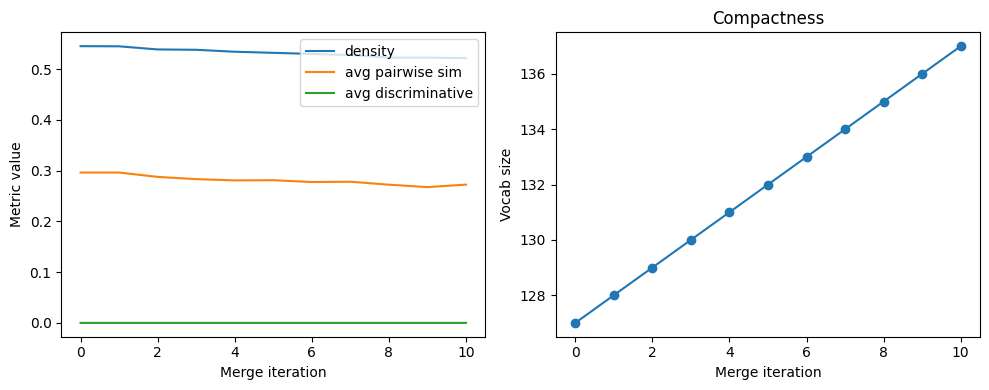

In [113]:
iters = list(range(len(metrics)))
density = [m["density"] for m in metrics]
pairwise = [m["pairwise_sim"] for m in metrics]
discrim = [m["discriminative"] for m in metrics]
vocab_size = [m["vocab_size"] for m in metrics]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(iters, density, label="density")
ax[0].plot(iters, pairwise, label="avg pairwise sim")
ax[0].plot(iters, discrim, label="avg discriminative")
ax[0].set_xlabel("Merge iteration")
ax[0].set_ylabel("Metric value")
ax[0].legend()

ax[1].plot(iters, vocab_size, marker="o")
ax[1].set_xlabel("Merge iteration")
ax[1].set_ylabel("Vocab size")
ax[1].set_title("Compactness")

plt.tight_layout()


## I. Visual Phrase Display

We display phrase constituents using exemplar patches for each visual word.


p0: [64, 109]
p1: [2, 114]
p2: [56, 76]
p3: [58, 61]
p4: [7, 13]


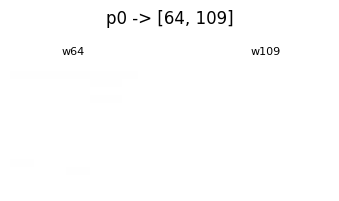

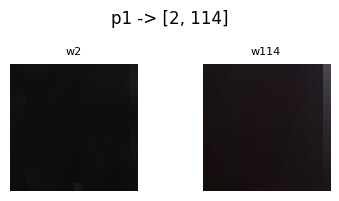

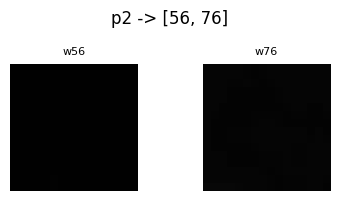

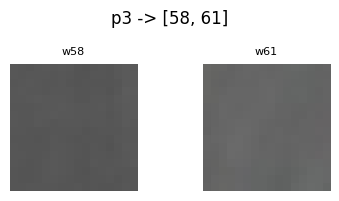

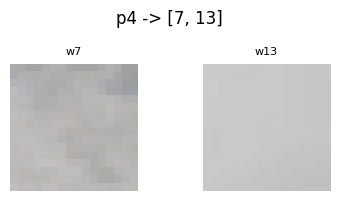

In [114]:
def show_phrase_exemplars(phrase_token, base_words, exemplars, max_words=9):
    base_words = sorted(base_words)[:max_words]
    if not base_words:
        return
    n = len(base_words)
    fig, axes = plt.subplots(1, n, figsize=(2 * n, 2))
    if n == 1:
        axes = [axes]
    for ax, wid in zip(axes, base_words):
        ax.imshow(exemplars[wid])
        ax.set_title(f"w{wid}", fontsize=8)
        ax.axis("off")
    fig.suptitle(f"{phrase_token} -> {base_words}")
    plt.tight_layout()

if merge_history:
    history_df = pd.DataFrame(merge_history)
    top_phrases = history_df.sort_values("avg_conf", ascending=False).head(5)
    for _, row in top_phrases.iterrows():
        token = row["new_token"]
        base_words = phrase_map.get(token, set())
        print(f"{token}: {sorted(base_words)}")
        show_phrase_exemplars(token, base_words, word_exemplars)
else:
    print("No phrases merged under current thresholds.")


### Phrase overlays on images (saved grids)

This visualization mirrors Good.ipynb: each word is colored with a border, and phrase occurrences are shown in grids of actual images.


In [115]:
import os

def make_word_color_lut(n_words, seed=0):
    rng = np.random.default_rng(seed)
    lut = rng.integers(32, 255, size=(n_words, 3), dtype=np.uint8)
    return lut

WORD_LUT = make_word_color_lut(K, seed=SEED)


def word_color(word_id):
    if 0 <= word_id < len(WORD_LUT):
        return tuple(int(c) for c in WORD_LUT[word_id])
    rng = np.random.default_rng(word_id)
    color = rng.integers(32, 255, size=3).tolist()
    return tuple(int(c) for c in color)


def draw_regions(img_rgb, regions, patch=PATCH_SIZE, alpha=0.35, border=2):
    if img_rgb is None:
        return None
    overlay = img_rgb.copy()
    H, W = overlay.shape[:2]
    for (r, c, wid) in regions:
        y0, y1 = r * patch, (r + 1) * patch
        x0, x1 = c * patch, (c + 1) * patch
        color = np.array(word_color(wid), dtype=np.float32)
        overlay[y0:y1, x0:x1] = (1 - alpha) * overlay[y0:y1, x0:x1] + alpha * color
        by0, by1 = max(0, y0), min(H, y1)
        bx0, bx1 = max(0, x0), min(W, x1)
        overlay[by0:by0 + border, bx0:bx1] = color
        overlay[by1 - border:by1, bx0:bx1] = color
        overlay[by0:by1, bx0:bx0 + border] = color
        overlay[by0:by1, bx1 - border:bx1] = color
    return overlay.astype(np.uint8)


def save_rgb_image(path, arr):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    if Image is not None:
        Image.fromarray(arr).save(path)
    else:
        import matplotlib.image as mpimg
        mpimg.imsave(path, arr)


def get_phrase_members(token):
    return sorted(phrase_map.get(token, set()))


def iter_phrase_occurrences(phrase_token, window_size=WINDOW_SIZE):
    members = set(get_phrase_members(phrase_token))
    if not members:
        return
    neigh = window_size // 2
    for img_idx, grid in enumerate(word_grids):
        gh, gw = grid.shape
        for r in range(gh):
            for c in range(gw):
                r0, r1 = max(0, r - neigh), min(gh, r + neigh + 1)
                c0, c1 = max(0, c - neigh), min(gw, c + neigh + 1)
                window = grid[r0:r1, c0:c1]
                present = set(int(x) for x in np.unique(window)) & members
                if not present:
                    continue
                regions = []
                for rr in range(r0, r1):
                    for cc in range(c0, c1):
                        wid = int(grid[rr, cc])
                        if wid in present:
                            regions.append((rr, cc, wid))
                strength = len(present) / max(1, len(members))
                yield img_idx, regions, strength, len(present)


def rank_phrase_occurrences(phrase_token, top_n=20):
    best_by_img = {}
    for img_idx, regions, strength, raw_count in iter_phrase_occurrences(phrase_token):
        current = best_by_img.get(img_idx)
        if current is None or (strength, raw_count) > (current[0], current[1]):
            best_by_img[img_idx] = (strength, raw_count, img_idx, regions)
    occ = list(best_by_img.values())
    occ.sort(key=lambda x: (x[0], x[1]), reverse=True)
    return occ[:top_n]


def run_phrase_visual_eval(phrases_to_eval, top_n=20, out_dir=os.path.join(RUN_DIR, "eval_phrases_martinet"), overwrite=True, save_individual=True, phrase_meta=None, params_text=None):
    if not phrases_to_eval:
        print("No phrases to evaluate. Run merge loop first.")
        return

    os.makedirs(out_dir, exist_ok=True)

    for phrase_id in phrases_to_eval:
        phrase_dir = os.path.join(out_dir, f"phrase_{phrase_id}")
        if os.path.exists(phrase_dir) and not overwrite:
            print(f"Skipping existing: {phrase_dir}")
            continue
        os.makedirs(phrase_dir, exist_ok=True)

        members = get_phrase_members(phrase_id)
        occ = rank_phrase_occurrences(phrase_id, top_n=top_n)
        if not occ:
            print(f"No occurrences found for {phrase_id}")
            continue

        n = len(occ)
        cols = 5
        rows = int(math.ceil(n / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = np.array(axes).reshape(-1)
        strengths = []

        for idx, (strength, raw_count, img_idx, regions) in enumerate(occ):
            strengths.append(strength)
            img = images[img_idx]
            if regions:
                img = draw_regions(img, regions, patch=PATCH_SIZE, alpha=0.35, border=2)
            axes[idx].imshow(img)
            axes[idx].set_title(f"img {img_idx} | s={strength:.2f}", fontsize=8)
            axes[idx].axis("off")

            if save_individual:
                out_path = os.path.join(phrase_dir, f"occ_{idx:02d}_img_{img_idx}.png")
                save_rgb_image(out_path, img)

        for ax in axes[n:]:
            ax.axis("off")

        avg_strength = float(np.mean(strengths)) if strengths else 0.0
        meta = phrase_meta.get(phrase_id, {}) if phrase_meta else {}
        conf = meta.get("avg_conf")
        word_ids = meta.get("word_ids", [])
        conf_text = f"conf={conf:.3f}" if conf is not None else "conf=?"
        words_text = "words=" + (",".join(str(w) for w in word_ids) if word_ids else "?")
        params_line = params_text if params_text else ""
        title = f"{phrase_id} | size={len(members)} | {conf_text} | {words_text} | avg strength={avg_strength:.2f}"
        if params_line:
            title = title + "\n" + params_line
        fig.suptitle(title, y=1.02)
        fig.tight_layout()
        fig_path = os.path.join(phrase_dir, "grid.png")
        fig.savefig(fig_path, dpi=200, bbox_inches="tight")
        plt.close(fig)



def build_phrase_meta(merge_history, phrase_map):
    meta = {}
    for row in merge_history:
        token = row.get("new_token")
        if not token:
            continue
        meta[token] = {
            "avg_conf": row.get("avg_conf"),
            "support": row.get("support"),
            "iteration": row.get("iteration"),
            "items": row.get("items"),
            "word_ids": sorted(phrase_map.get(token, set())),
        }
    return meta
def save_phrase_word_combinations(phrase_tokens, out_path):
    rows = []
    for token in phrase_tokens:
        word_ids = get_phrase_members(token)
        word_labels = "+".join([f"w{wid}" for wid in word_ids])
        word_colors = "+".join([str(word_color(wid)) for wid in word_ids])
        rows.append({
            "phrase": token,
            "word_labels": word_labels,
            "word_ids": ",".join(str(wid) for wid in word_ids),
            "word_colors_rgb": word_colors,
        })
    if rows:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        pd.DataFrame(rows).to_csv(out_path, index=False)
        print("Saved phrase combinations to:", out_path)

# Example usage: visualize top phrases (by avg confidence) like Good.ipynb
if merge_history:
    history_df = pd.DataFrame(merge_history)
    top_phrase_tokens = history_df.sort_values("avg_conf", ascending=False)["new_token"].head(5).tolist()
    all_phrase_tokens = history_df["new_token"].tolist()
    save_phrase_word_combinations(all_phrase_tokens, os.path.join(RUN_DIR, "eval_phrases_martinet", "phrase_word_combinations.csv"))
    phrase_meta = build_phrase_meta(merge_history, phrase_map)
    params_text = f"ps={PATCH_SIZE}, ws={WINDOW_SIZE}, K={K}, ms={MIN_SUPPORT}, mc={MIN_CONF}"
    run_phrase_visual_eval(
        top_phrase_tokens,
        top_n=20,
        out_dir=os.path.join(RUN_DIR, "eval_phrases_martinet"),
        overwrite=True,
        phrase_meta=phrase_meta,
        params_text=params_text,
    )


Saved phrase combinations to: runs/run_005_ps16_ws5_k128_ms0.002_mc0.3/eval_phrases_martinet/phrase_word_combinations.csv


## J. Parameter Sweep

A small sweep over patch size, window size, K, minsupport, and minconfidence. The sweep uses a smaller subset for speed.


In [ ]:
def run_pipeline(images, patch_size, window_size, k, min_support, min_conf, max_merges=6):
    all_patches = []
    all_features = []
    image_slices = []

    for img in images:
        patches, positions, grid_shape = extract_patches(img, patch_size, patch_size)
        feats = [patch_to_feature(p, FEATURE_SIZE, GRAYSCALE) for p in patches]
        start = len(all_patches)
        all_patches.extend(patches)
        all_features.extend(feats)
        end = len(all_patches)
        image_slices.append((start, end, grid_shape))

    if not all_features:
        return None
    feats = np.stack(all_features)
    km = MiniBatchKMeans(n_clusters=k, random_state=SEED, batch_size=256, n_init=3)
    km.fit(feats)
    labels = km.predict(feats)

    grids = []
    for start, end, grid_shape in image_slices:
        grids.append(labels[start:end].reshape(grid_shape))

    tx_per_img = build_transactions_from_grids(grids, window_size)
    transactions = [list(t) for txs in tx_per_img for t in txs]
    _, rules = mine_rules(transactions, min_support, min_conf, MAX_ITEMSET)
    n_rules = 0 if rules is None else len(rules)

    merged_tx, phrase_map, history, metrics = merge_loop(
        tx_per_img, min_support, min_conf, max_merges, MAX_ITEMSET
    )
    final_metrics = metrics[-1]

    return {
        "patch_size": patch_size,
        "window_size": window_size,
        "K": k,
        "min_support": min_support,
        "min_conf": min_conf,
        "n_rules": n_rules,
        "n_merges": len(history),
        "final_vocab": final_metrics["vocab_size"],
        "final_density": final_metrics["density"],
        "final_pairwise": final_metrics["pairwise_sim"],
        "final_discriminative": final_metrics["discriminative"],
    }

sweep_images = images[: min(120, len(images))]
params = []
for patch_size in [ 32]:
    for window_size in [3, 5]:
        for k in [64, 128]:
            for min_support in [0.01,0.001, 0.002, 0.003, 0.005]:
                for min_conf in [0.2, 0.25,0.3]:
                    params.append((patch_size, window_size, k, min_support, min_conf))

sweep_results = []
for patch_size, window_size, k, min_support, min_conf in tqdm(params, desc="Sweep"):
    res = run_pipeline(sweep_images, patch_size, window_size, k, min_support, min_conf)
    if res is not None:
        sweep_results.append(res)

sweep_df = pd.DataFrame(sweep_results)
if not sweep_df.empty:
    display(sweep_df.sort_values("final_density", ascending=False).head(10))


Sweep:   3%|▎         | 1/32 [00:30<15:31, 30.05s/it]


KeyboardInterrupt: 

## K. How this notebook differs from Good.ipynb

- Uses strict Apriori with explicit minsupport/minconfidence thresholds.
- Enforces symmetric rules (X => Y and Y => X) before any merge.
- Performs iterative re-mining after each merge, creating explicit phrase tokens.
- Tracks paper-style density, pairwise similarity, and discriminative power curves.
